In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from modeling_data import Data_Import
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from six import StringIO  
from IPython.display import Image  
import pydotplus
%matplotlib inline

# Initialize progress bars for pandas
tqdm.pandas()

In [3]:
# Load cleaned dataset
data = Data_Import()

## Decision Tree Classifier

I want to use a decision tree classifier model because it can give me some interpretable outputs, such as a tree and feature importances. I will see if these outputs give me any insights into my data. First, I will determine the best max\_depth for the tree.



In [4]:
# Without max_depth
dtc = DecisionTreeClassifier()
dtc.fit(data.X_train, data.y_train)
yhat = dtc.predict(data.X_test)
print(accuracy_score(data.y_test,yhat))
print(dtc.get_depth())

0.3696279069767442
68


In [5]:
# Test different max_depths
train_acc = []
test_acc = []

allds = list(range(1, 70, 1))

for d in tqdm(allds):
    dtc = DecisionTreeClassifier(max_depth=d)
    dtc.fit(data.X_train, data.y_train)
    yhat_train = dtc.predict(data.X_train)
    yhat = dtc.predict(data.X_test)
    train_acc.append(accuracy_score(data.y_train,yhat_train))
    test_acc.append(accuracy_score(data.y_test,yhat))

  0%|          | 0/69 [00:00<?, ?it/s]

Highest accuracy is 0.3834418604651163 with max_depth 39


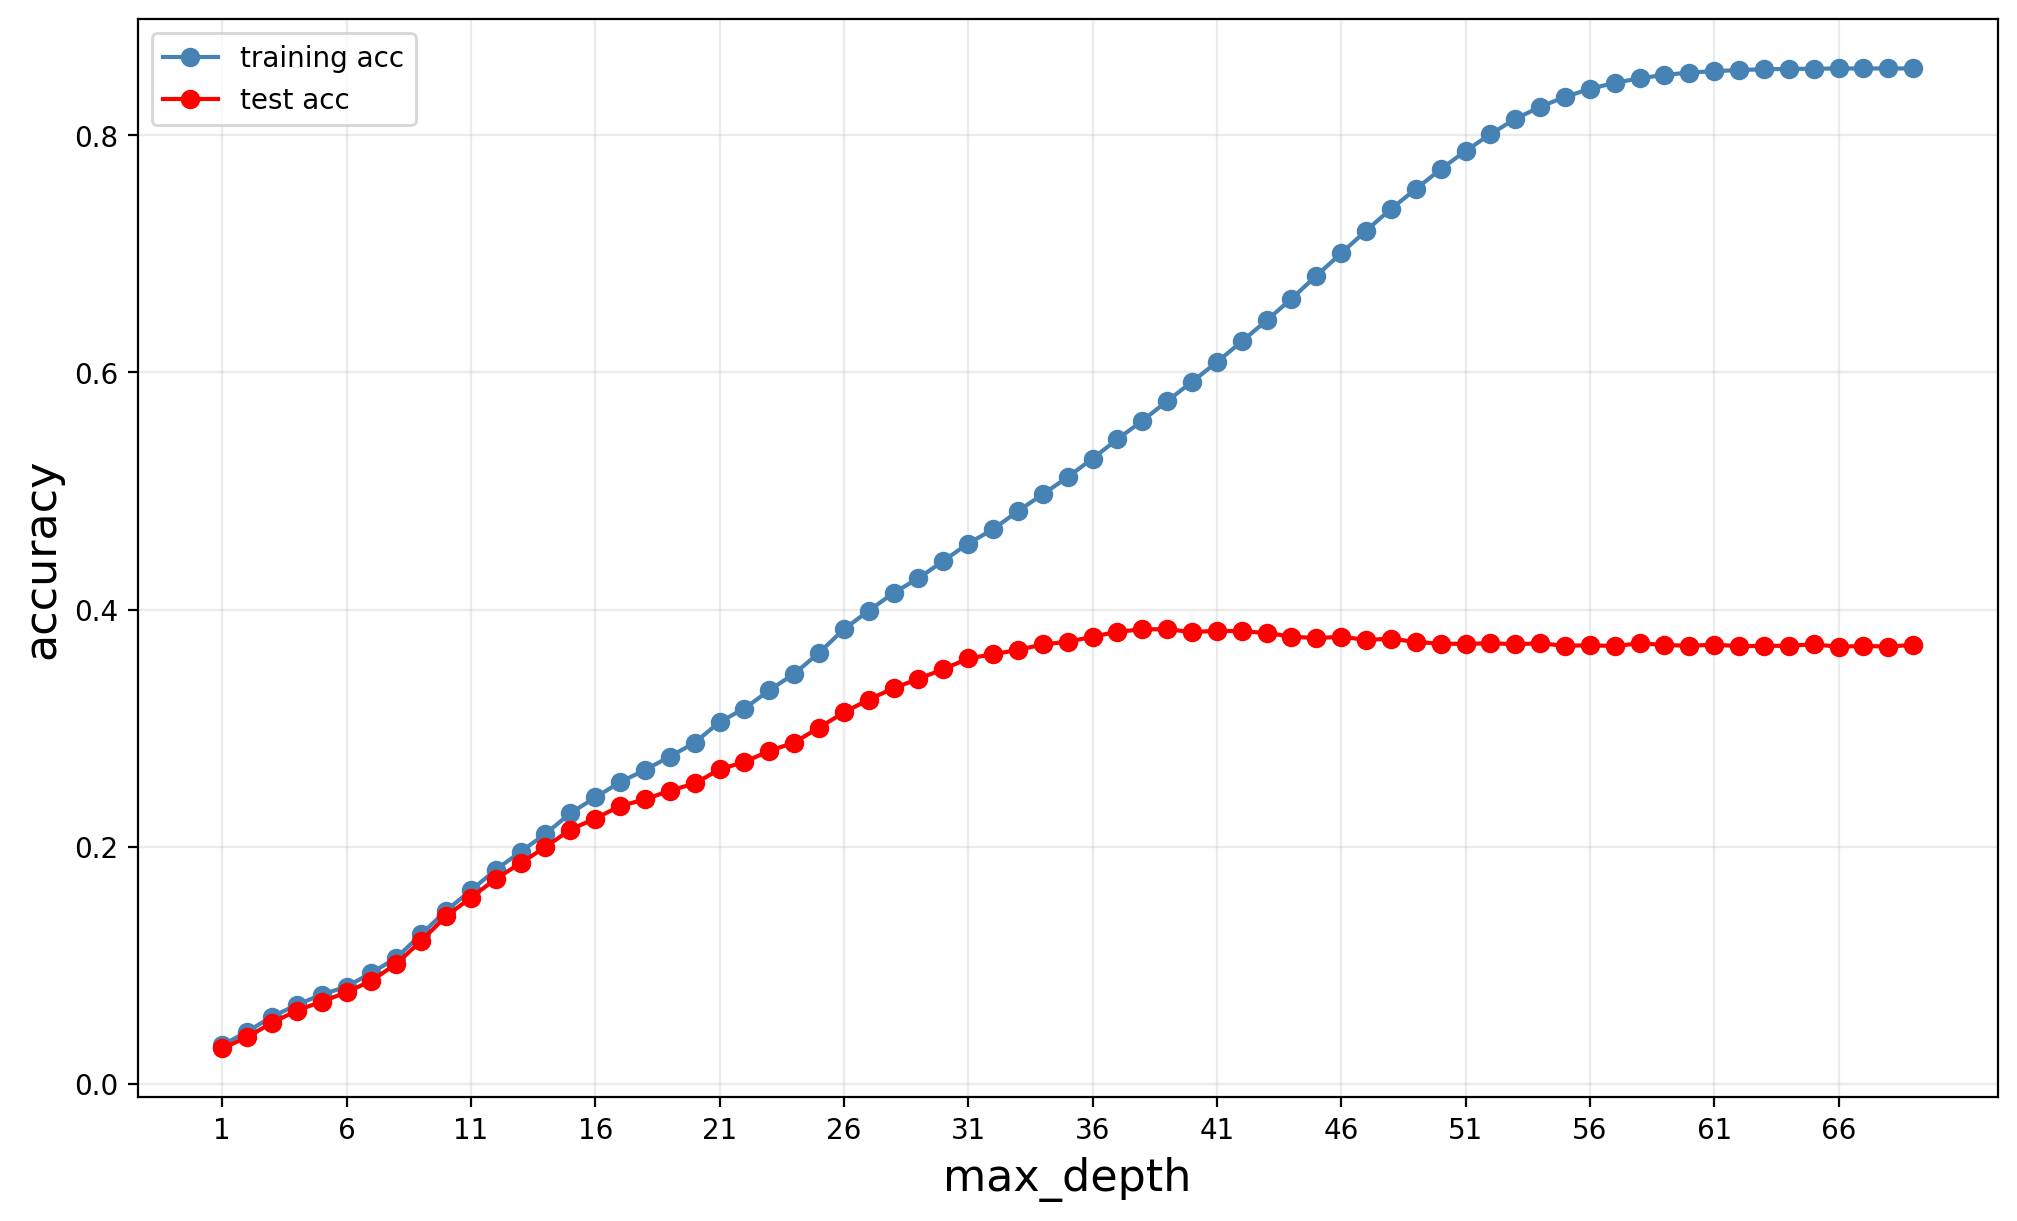

In [6]:
# Plot the accuracies
highest_acc_ind = np.argmax(test_acc)
best_max_depth = allds[highest_acc_ind]
print("Highest accuracy is {} with max_depth {}".format(test_acc[highest_acc_ind], best_max_depth))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allds, train_acc, marker="o", color="steelblue", label="training acc")
ax.plot(allds, test_acc, marker="o", color="red", label="test acc")
ax.set_xlabel("max_depth", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
leg = plt.legend()
plt.xticks(range(1, 70, 5))
ax.grid(alpha=0.25)

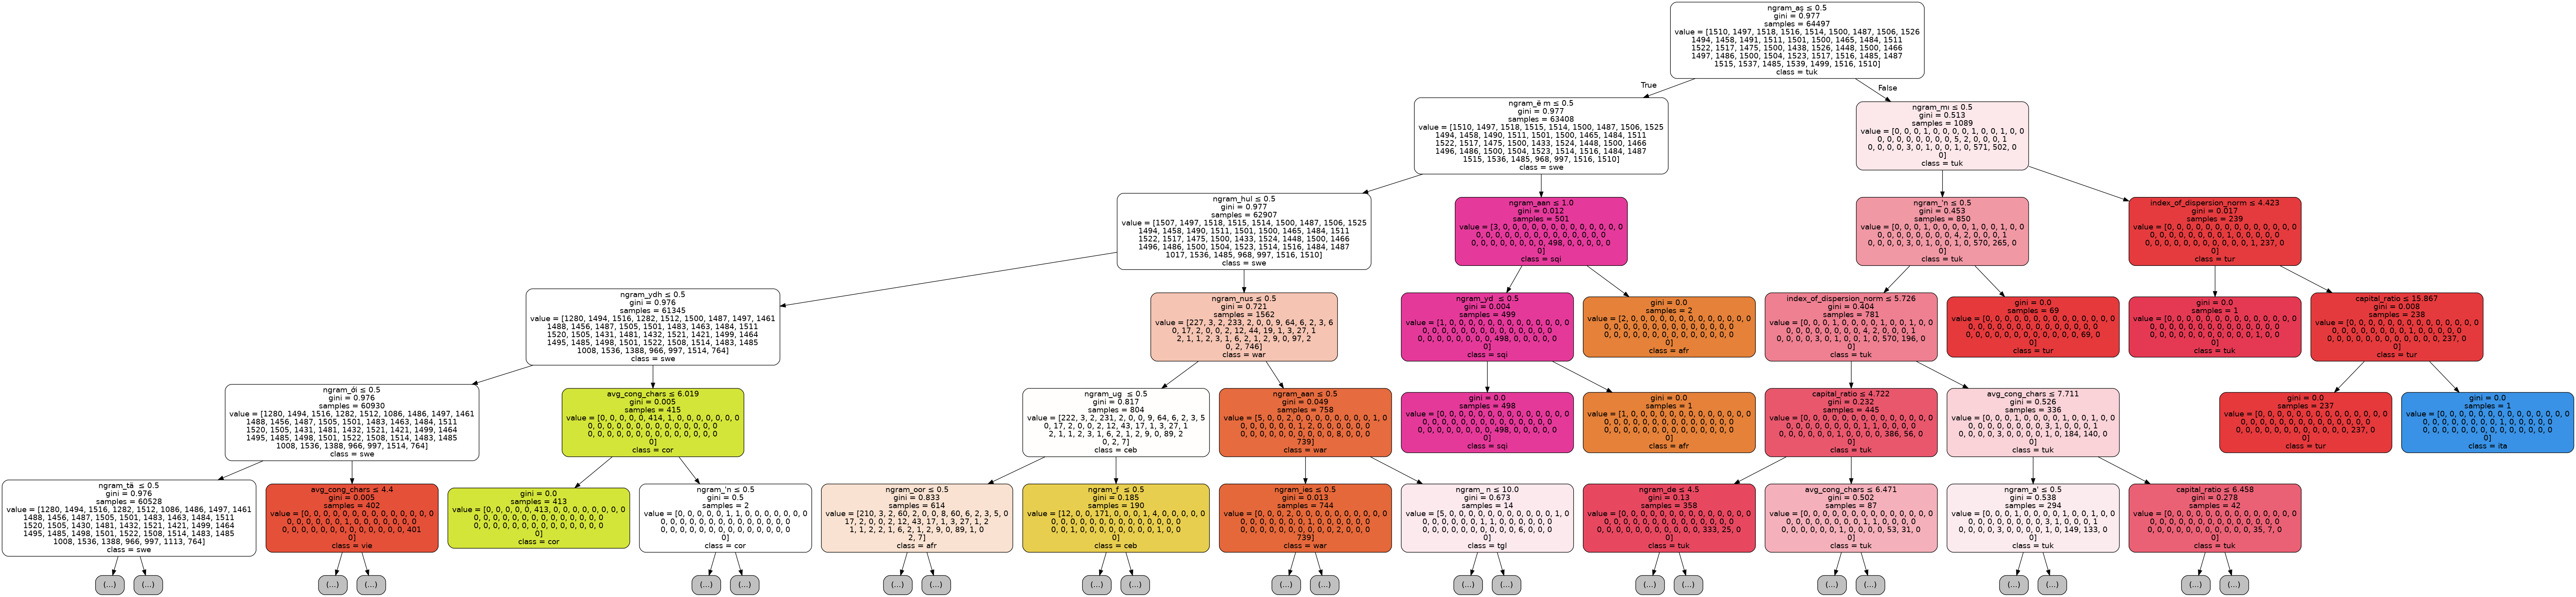

In [7]:
# Make a tree image of the best model
best_dtc = DecisionTreeClassifier(max_depth=best_max_depth).fit(data.X_train,data.y_train)
dot_data = StringIO()
export_graphviz(best_dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = data.X.columns, 
                class_names=data.le.inverse_transform(dtc.classes_),
                max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('images/decision_tree.png')
Image(graph.create_png())

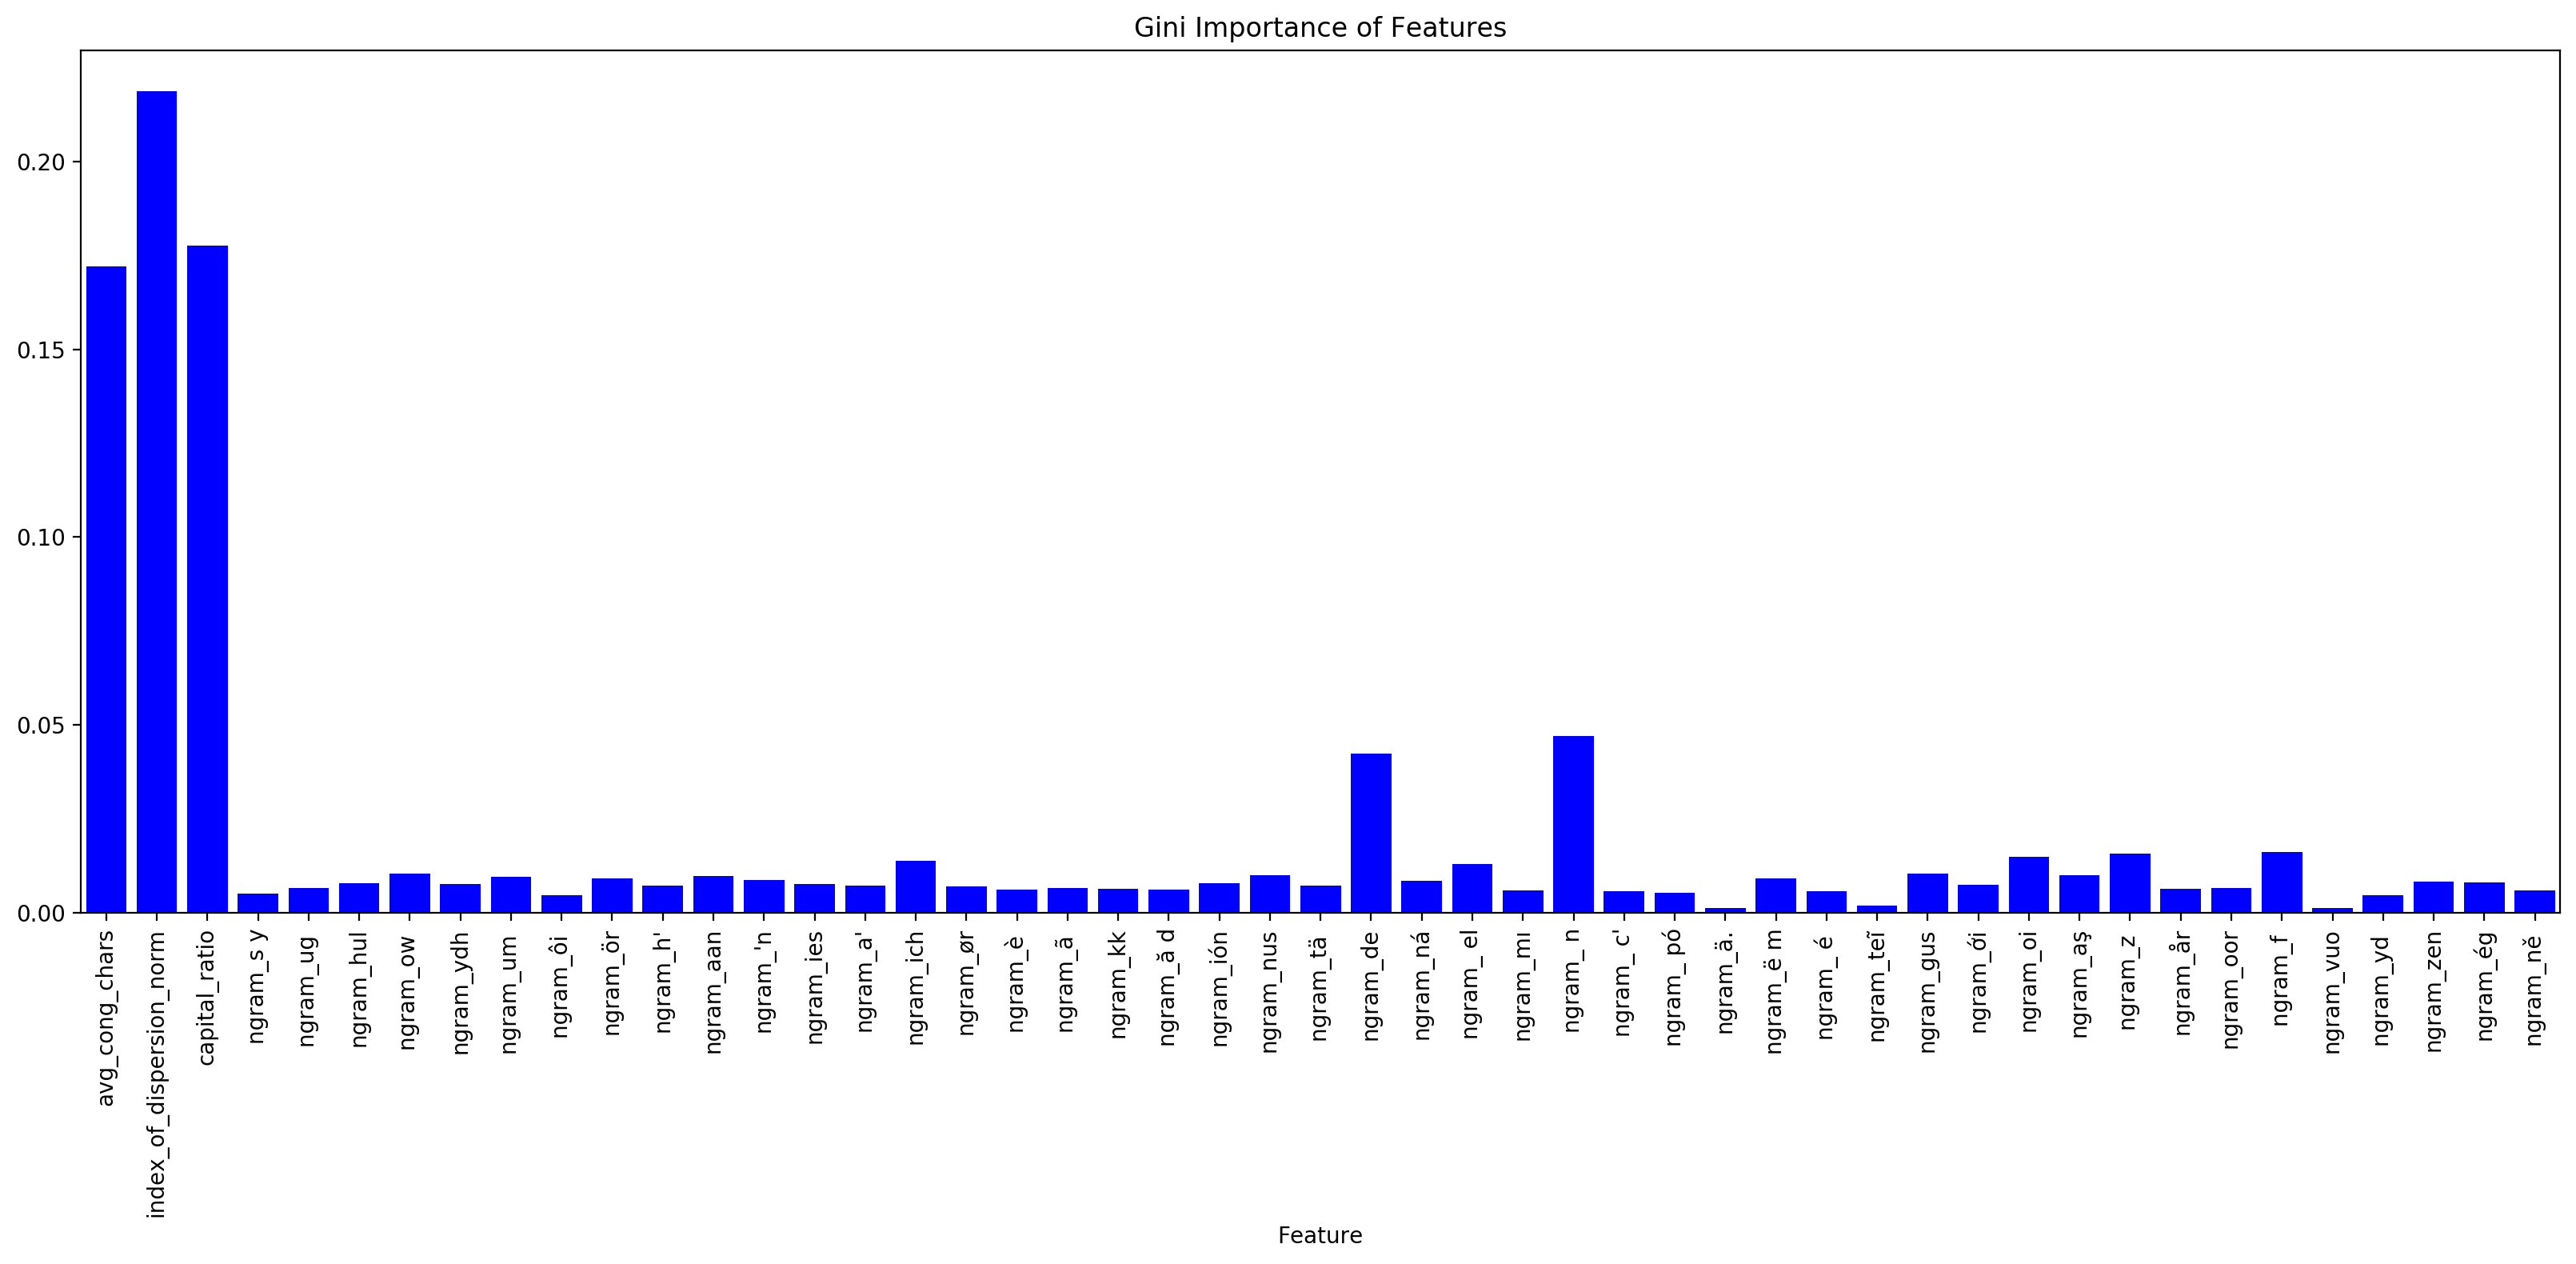

In [8]:
# Compute feature importance
importance = dtc.feature_importances_

# Plot the weights
importance_df = pd.DataFrame({'Importance': importance,
                        'Feature': data.X.columns
                       })

importance_df.plot(y='Importance', x='Feature', kind='bar', color='none', legend=False, figsize=(20,7))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title("Gini Importance of Features")
plt.show()

## Random Forest Classifier

Now, I will see if the Random Forest Classifier improves on the decision tree. 



In [21]:
# Random Forest
rfc = RandomForestClassifier(random_state=0, max_depth=best_max_depth, n_jobs=-4)
rfc.fit(data.X_train, data.y_train)
y_pred = rfc.predict(data.X_test) 
print("Accuracy: {}".format(accuracy_score(data.y_test, y_pred)))

Accuracy: 0.4518604651162791


## Analysis

Now that I have determined that the best model is a Random Forest Classifier with a max\_depth of 42, I will create some visualizations to help with analysis.



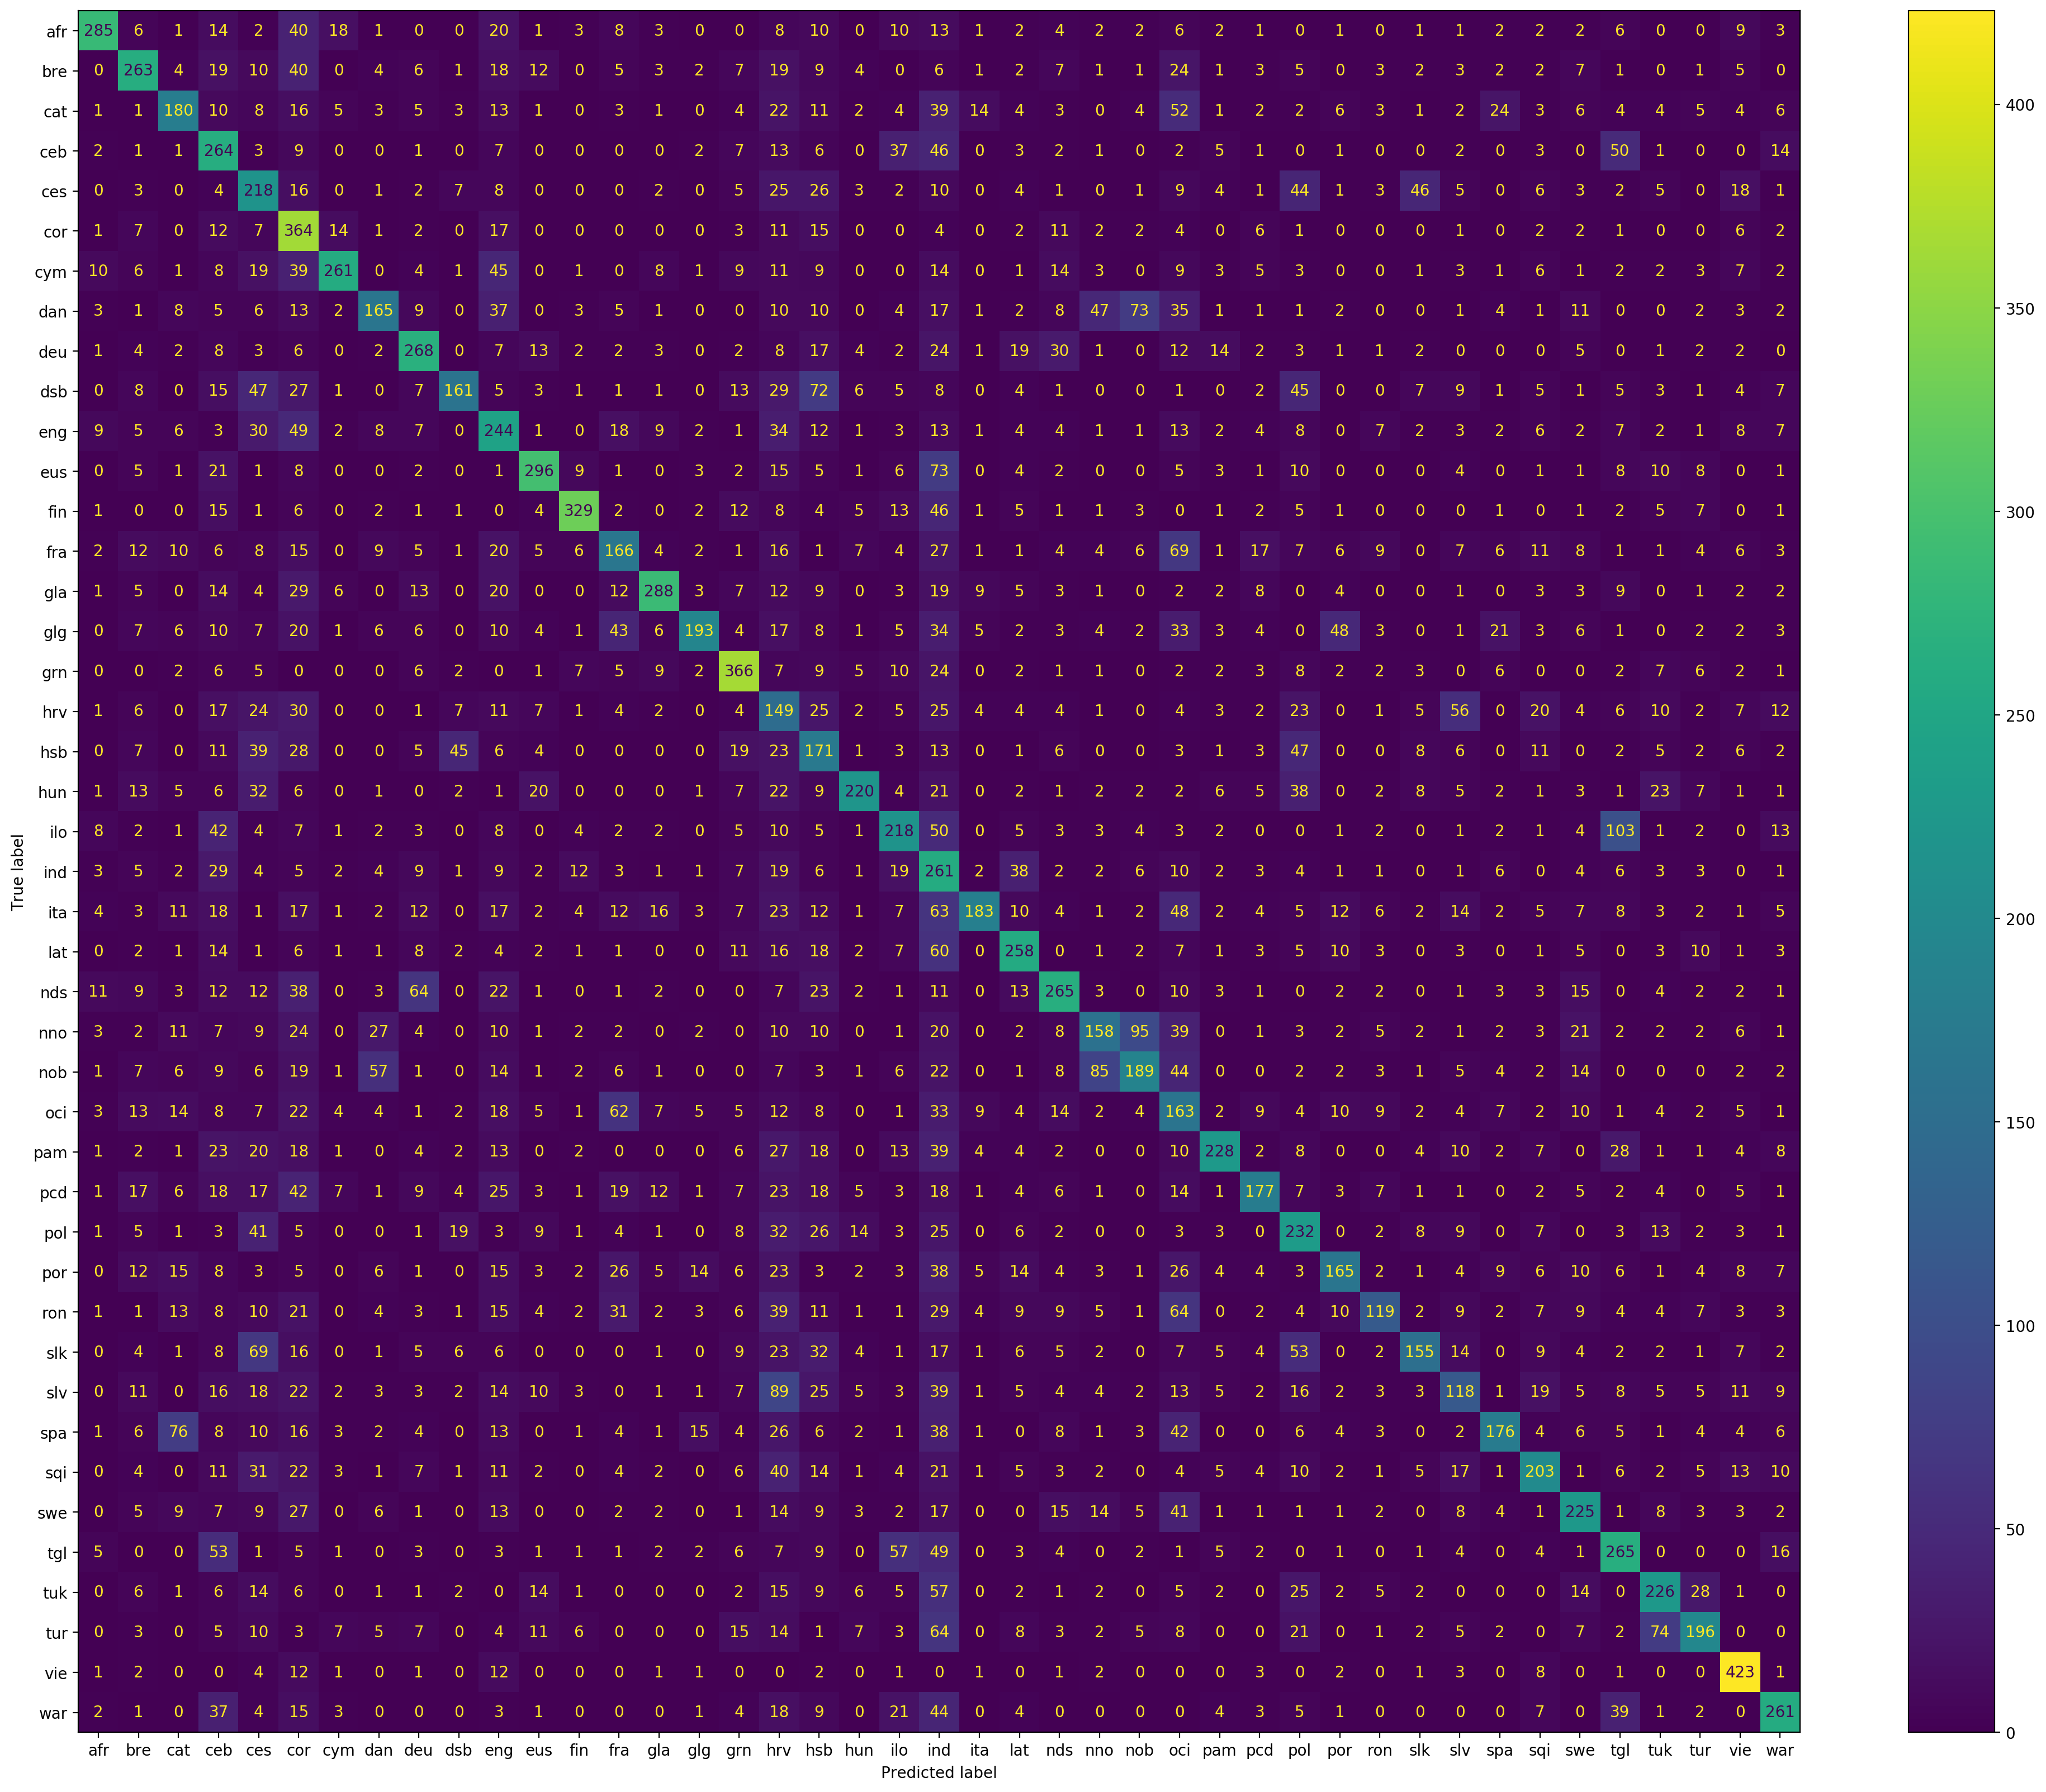

In [10]:
# Confusion Matrix of best model
fig, ax = plt.subplots(figsize=(25, 20))
labels = data.le.inverse_transform(rfc.classes_)
disp = ConfusionMatrixDisplay.from_predictions(data.y_test, y_pred, labels=rfc.classes_, display_labels=labels, ax=ax)
plt.show()

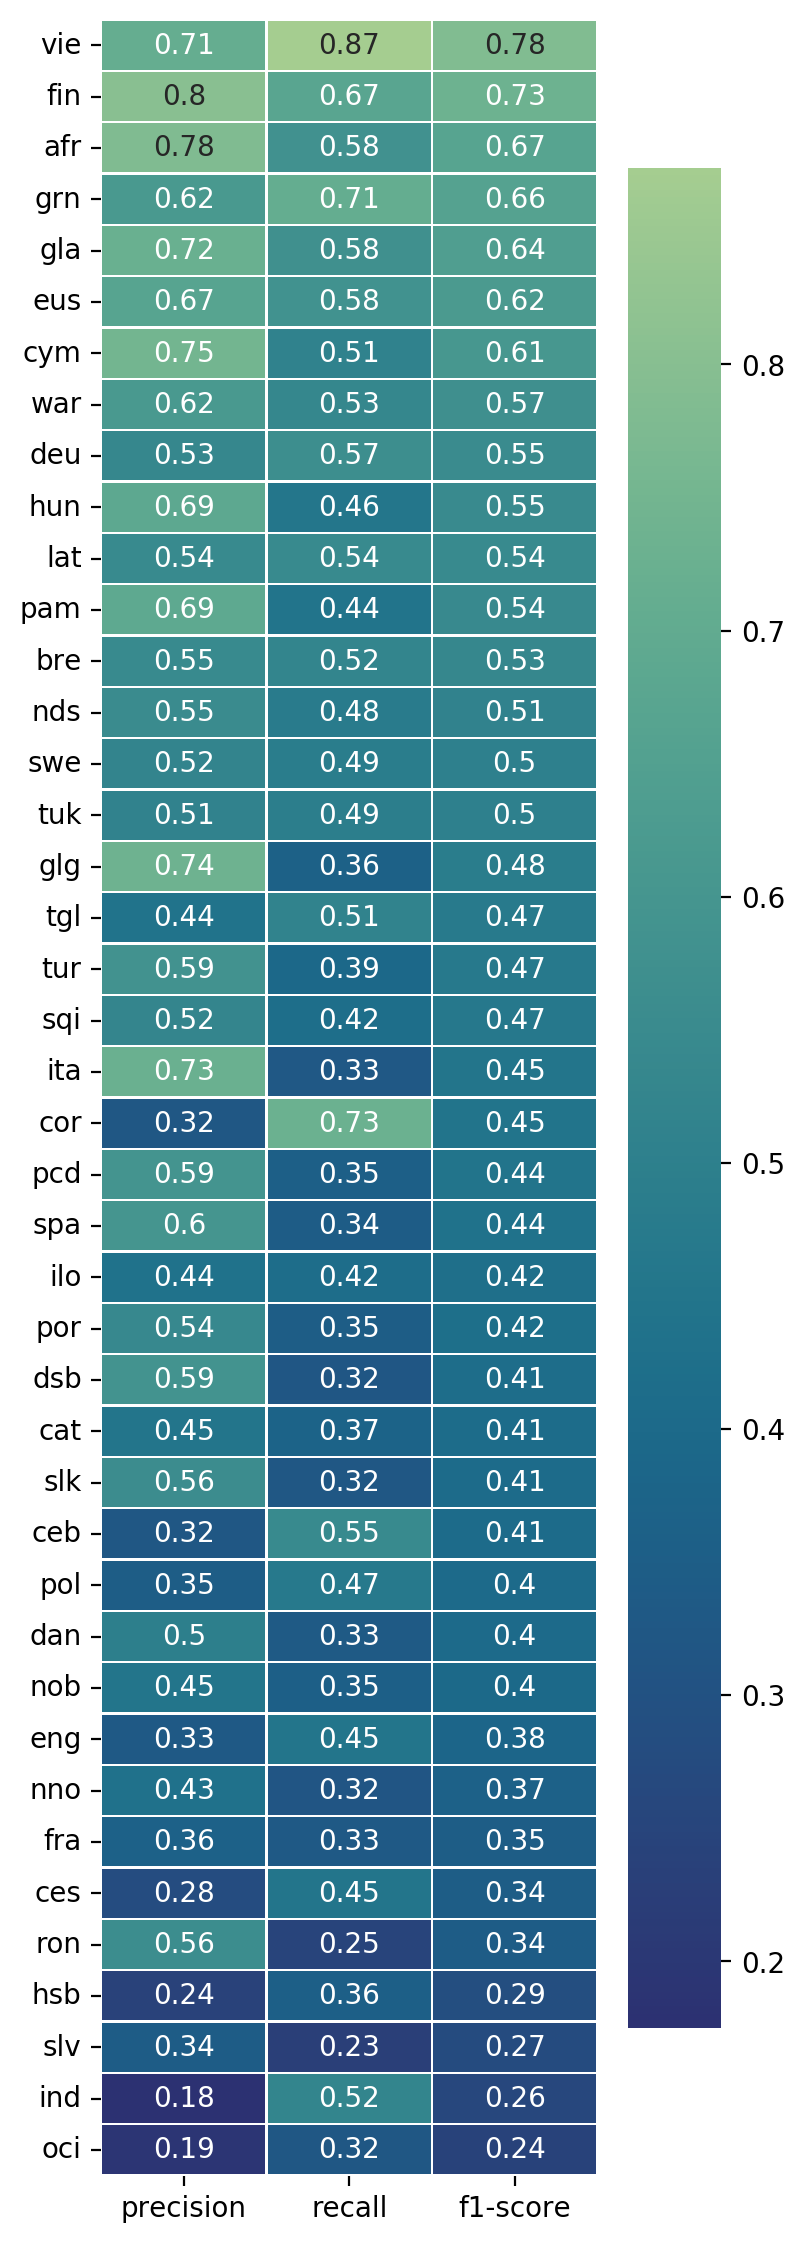

In [11]:
# Classification report of best model

report = classification_report(data.y_test, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose().sort_values("f1-score",ascending=False)
report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
report_df.drop(["support"], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(4,14)) 
sns.heatmap(pd.DataFrame(report_df).iloc[:-1, :], annot=True, linewidths=.5,ax=ax,cmap="crest_r")